# Assignment 1 

I have chosen to answer question 1, 2 and 5 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb
from chainconsumer import ChainConsumer
from matplotlib.lines import Line2D
import scipy.optimize as op

## Question 1 

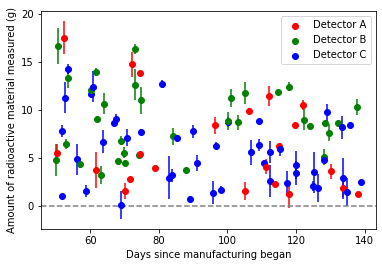

In [2]:
#quickly reproduce the plot of the data
data = pd.read_csv('decay.csv')
days_to_seconds = 60*60*24
time = data.time_measured_in_seconds
mass = data.grams_measured
mass_u = data.uncertainty_in_grams_measured
d_name = data.detector_name

plt.xlabel('Days since manufacturing began')
plt.ylabel('Amount of radioactive material measured (g)')
for i in range(len(time)):
    if str(d_name[i]) == 'A':
         plt.errorbar(time[i]/days_to_seconds, mass[i], yerr = mass_u[i], fmt='o', c = 'r')
    elif str(d_name[i]) == 'B':
        plt.errorbar(time[i]/days_to_seconds, mass[i], yerr = mass_u[i], fmt='o', c = 'g' )
    elif str(d_name[i]) == 'C':
        plt.errorbar(time[i]/days_to_seconds, mass[i], yerr = mass_u[i], fmt='o', c = 'b')
        
plt.axhline(y=0, color='grey', linestyle='--')

legend_elements = [
    plt.scatter([], [], marker='o', color='r', label='Detector A'),
    plt.scatter([], [], marker='o', color='g', label='Detector B'),
    plt.scatter([], [], marker='o', color='b', label='Detector C')
    ]
plt.legend(handles = legend_elements)
plt.show()

### Part 1 

A company has tasked us with infering the decay rate of the radioactive material in thier widgets. 
Some important information that they can give us is: 
- The detectors used to measure the amount of radioactive material has uncertainties that are normally distributed
- The company does not know how much radioactive material was initialy in the widgets but it must be less than 20 grams 
- The company does not know when each widget was made, only that they made all 100 widgets within 35 days and it took 14 days to start an investigation
- Each widget was only measured once and took 90 days to complete the investigation (50 - 139 days since start of manufacturing)

However we do know that the amount of radioactive material $N$ at any time $t$ is given by:

$$
N = N_0\exp\left(-\alpha\left[t-t_0\right]\right)
$$


In order to infer the decay rate I will employ Stan.
Since the detectors have uncertainties that are normally distributed the measured amount of radioactive material will be drawn from 

$$
N_{1,i}  \sim \mathcal{N}\left(N_{0,i}\exp\left(-\alpha\left[t_{1,i}-t_{0,i}\right]\right), \sigma_i\right)
$$
Where the subscript 0 corresponds to when the widget was manufactured while 1 corresponds to when the data was taken.\
We can already infer some priors for our model with the information the company shared with us such as:

$$
N_{0,i} \sim \mathcal{U}(0, N_{0,max})
$$
Where we are told that the maximum amount of radioactive material is $N_{0,max} = 20g$.

$$
t_{0,i} \sim \mathcal{U}(t_{0,min},t_{0,max})
$$
Since we know the time of manufacture is bounded within the first 35 days. 

Since we are given $N_{0,max}$ we can implicitly obtain a maximum value for the decay rate $\alpha$, The maximum possible rate would occur when, 

$$
min(N_1) = max(N_0)exp(-\alpha_{max}[min(t_1)- max(t_0)])
$$
Where $min(t_1)- max(t_0) = \Delta t$ is the delay between the end of production and start of the investigation (14 days).\
Rearanging we get: 

$$
\alpha_{max} = -\frac{1}{\Delta t} \ln \left(\frac{{\min(N_1)}}{{\max(N_0)}}\right)
$$

Therefore the prior we can set on $\alpha$ is: 

$$
\alpha \sim \mathcal{U}(0, \alpha_{max})
$$

The minimum measured material is $\min(N_1) = 0.0787g$, while $\max(N_0) = 20g$, therefore we can conclude that maximum decay rate of the material will be $\alpha_{max} = 4.58\times 10^{-6} /s$ which corresoponds to a half-life of $T_{1/2} = 42.05 s$

I want to note that since $min(N_1)$ was actually measured about a month after manufacturing had ended (not 14 days), that implies that $\alpha_{max}$ must be larger that the true value, this could be repeated with any datapoint.

In [3]:
alpha_max = -1/(14*24*3600) * np.log(min(mass)/20)
half_life  = np.log(2)/alpha_max
print(alpha_max,half_life/3600)

4.578285542585259e-06 42.055236987282804


In [21]:
from cmdstanpy import CmdStanModel

In [5]:
text = '''
data {
    // number of widgets
    int<lower=1> N_widget;
    
    //measured radioactive material
    vector[N_widget] N_measured;
    
    //and the uncertainty
    vector[N_widget] sigma_N_measured;

    // time of measurement
    vector[N_widget] t_measured;
    
    //maximum amound of initial material
    real N_init_max;
    
    //maximum decay rate
    real alpha_max; 
    
    //last day in manufacturing
    real t_init_max;

}

parameters {
    // Manufactured time
    vector<lower=0, upper = t_init_max>[N_widget] t_init;
    
    //initial material
    vector<lower= 0, upper = N_init_max>[N_widget] N_init;
    
    //The decay rate
    real<lower = 0, upper = alpha_max> alpha; 
}

model {
    for (n in 1:N_widget) {
       N_measured[n] ~ normal(
           N_init[n] * exp(-alpha*(t_measured[n] - t_init[n])), sigma_N_measured[n]
        );
    }
}

'''

file_path = "A1Q1P1.stan"

# Open the file in write mode and write the text
with open(file_path, "w") as file:
    file.write(text)





In [6]:
model = CmdStanModel(stan_file='A1Q1P1.stan')

# Data.
data = dict(
    N_widget = 100,
    N_measured = mass,
    sigma_N_measured = mass_u ,
    t_measured = time,
    N_init_max = 20,
    alpha_max = alpha_max,
    t_init_max = 14*24*3600,
)

fit_p1 = model.sample(data = data)





13:25:20 - cmdstanpy - INFO - compiling stan file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P1.stan to exe file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P1
13:25:32 - cmdstanpy - INFO - compiled model executable: /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P1
13:25:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:25:47 - cmdstanpy - INFO - CmdStan done processing.


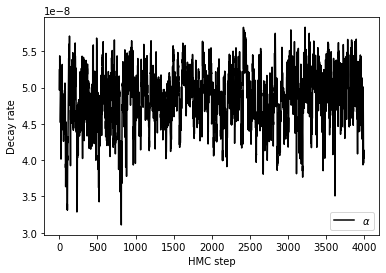

In [7]:
plt.xlabel('HMC step')
plt.ylabel('Decay rate')
plt.plot(fit_p1.alpha, c = 'black', label = '$\u03B1$')
plt.legend()
plt.show()

Text(55.0, 0.5, 'Posterior probability')

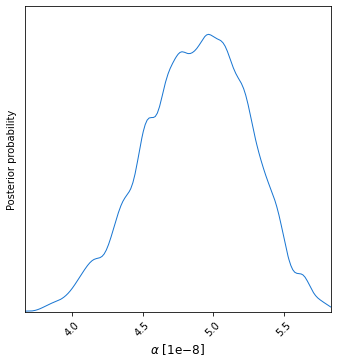

In [8]:
c = ChainConsumer()
c.add_chain(fit_p1.alpha[2000:], parameters=['$\u03B1$']) #remove the burn in
fig = c.plotter.plot(filename="example.png", figsize="column")
plt.ylabel("Posterior probability")


The infered decay rate from the above model is thus $\alpha = 49.3^{+4.0}_{-3.8} \times 10^{-9}   s^{-1}$, which corresponds to a half-life of about $T_{1/2} = 163$ days.

### Part 2

Of the three detectors that was used to measure tha amount of radioactive material, the company is suspicious that on of those is giving a biased measurement. They have asked us to infer which detector is giving these biased measurements and to infer what the level of that bias is.

Lets introduce a new parameter $b$ to the model, which is the level of the bias. Consequently I will also introduce another parameter $\pi_k$, which is the probability that detector k has the bias. Where,

$$
\pi_k \sim Multinomial(K)
$$

and since we have no prior information on the bias, it shall be drawn from, 

$$
b \sim \mathcal{U}(-\infty,\infty).
$$

The addition of a bias term in the detector has the overall effect of shifting the measured material such that:

$$
N_1,k = N_0\exp\left(-\alpha\left[t_1-t_0\right]\right) + B_k
$$

Where $B_k$ is the bias in detector $k$ and its expected value will be the probability that the detector is faulty ($\pi_k$) mulitplied by the bias ($b$). 

Resulting with a model of:
$$
N_{1,i,k}  \sim \mathcal{N}\left(N_{0,i}\exp\left(-\alpha\left[t_{1,i}-t_{0,i}\right]\right) + \pi_kb, \sigma_i\right)
$$




In [9]:
text = '''
data {
    // number of widgets
    int<lower=1> N_widget;
    
    //measured radioactive material
    vector[N_widget] N_measured;
    
    //and the uncertainty
    vector[N_widget] sigma_N_measured;

    // time of measurement
    vector[N_widget] t_measured;
    
    //maximum amound of initial material
    real N_init_max;
    
    //maximum decay rate
    real alpha_max; 
    
    //last day in manufacturing
    real t_init_max;
    
    //detector
    int k[N_widget];

}

parameters {
    // Manufactured time
    vector<lower=0, upper = t_init_max>[N_widget] t_init;
    
    //initial material
    vector<lower= 0, upper = N_init_max>[N_widget] N_init;
    
    //The decay rate
    real<lower = 0, upper = alpha_max> alpha; 
    
    // The bias in the detector
    real b;
    
    //multinomial
    simplex[3] pi;
}


model {
    for (n in 1:N_widget) {
       N_measured[n] ~ normal(
           N_init[n] * exp(-alpha*(t_measured[n] - t_init[n]))
           + pi[k[n]] * b, 
           sigma_N_measured[n]
        );
    }
}

'''

file_path = "A1Q1P2.stan"

# Open the file in write mode and write the text
with open(file_path, "w") as file:
    file.write(text)


In [10]:
#change classification from "A", "B", "C" to 1,2,3
d_name_i = []
for n in range(len(d_name)):
    if d_name[n] == "A":
        d_name_i.append(1)
    elif d_name[n] == "B":
        d_name_i.append(2)
    elif d_name[n] == "C":
        d_name_i.append(3)

        
model = CmdStanModel(stan_file='A1Q1P2.stan')     
        
# Data.
data = dict(
    N_widget = 100,
    N_measured = mass,
    sigma_N_measured = mass_u ,
    t_measured = time,
    N_init_max = 20,
    alpha_max = alpha_max,
    t_init_max = 14*24*3600,
    k = d_name_i,
)

fit_p2 = model.sample(data = data)


13:25:48 - cmdstanpy - INFO - compiling stan file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2.stan to exe file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2
INFO:cmdstanpy:compiling stan file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2.stan to exe file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2
DEBUG:cmdstanpy:cmd: make /tmp/tmp_okgzhu_/tmpwsrlls2h
cwd: /home/lewis/.cmdstan/cmdstan-2.32.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmp_okgzhu_/tmpwsrlls2h.hpp /tmp/tmp_okgzhu_/tmpwsrlls2h.stan
Warning in '/tmp/tmp_okgzhu_/tmpwsrlls2h.stan', line 25, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Comp

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2', 'id=1', 'random', 'seed=6557', 'data', 'file=/tmp/tmp3ybc7pxd/l3i_nr0w.json', 'output', 'file=/tmp/tmp3ybc7pxd/A1Q1P2uv081x0k/A1Q1P2-20230609132558_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2', 'id=2', 'random', 'seed=6557', 'data', 'file=/tmp/tmp3ybc7pxd/l3i_nr0w.json', 'output', 'file=/tmp/tmp3ybc7pxd/A1Q1P2uv081x0k/A1Q1P2-20230609132558_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/home/lewis/Documents/Honours/Machine learni

13:26:34 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q1P2', 'id=1', 'random', 'seed=6557', 'data', 'file=/tmp/tmp3ybc7pxd/l3i_nr0w.json', 'output', 'file=/tmp/tmp3ybc7pxd/A1Q1P2uv081x0k/A1Q1P2-20230609132558_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp3ybc7pxd/A1Q1P2uv081x0k/A1Q1P2-20230609132558_1.csv
 console_msgs (if any):
	/tmp/tmp3ybc7pxd/A1Q1P2uv081x0k/A1Q1P2-20230609132558_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta

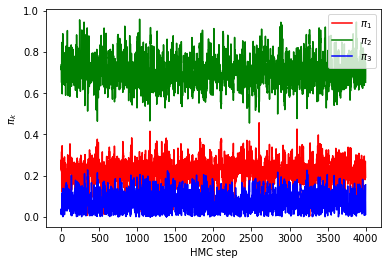

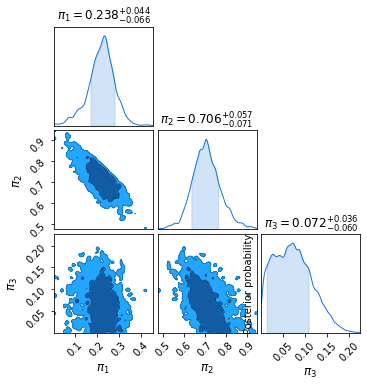

In [11]:
pi_k = fit_p2.pi.T

plt.xlabel('HMC step')
plt.ylabel('$\pi_k$')
plt.plot(pi_k[0], c = 'r', label = '$\pi_{1}$')
plt.plot(pi_k[1], c = 'g', label = '$\pi_{2}$')
plt.plot(pi_k[2], c = 'b', label = '$\pi_{3}$')
plt.legend(loc = 'upper right')
plt.show()

c = ChainConsumer()
chain1 = [pi_k[0][2000:],pi_k[1][2000:],pi_k[2][2000:]]
c.add_chain(chain1, parameters=["$\pi_1$","$\pi_2$","$\pi_3$"]) #remove the burn in
fig = c.plotter.plot(filename="example.png", figsize="column")
plt.ylabel("Posterior probability")
plt.show()

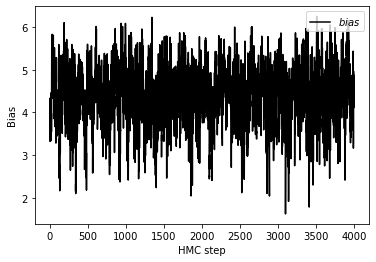

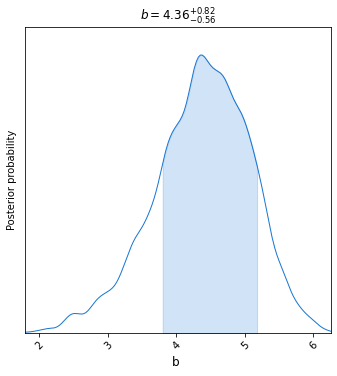

In [12]:
plt.xlabel('HMC step')
plt.ylabel('Bias')
plt.plot(fit_p2.b, c = 'black', label = '$bias$')
plt.legend(loc = 'upper right')
plt.show()

c = ChainConsumer()
c.add_chain(fit_p2.b, parameters=["b"]) #remove the burn in
fig = c.plotter.plot(filename="example.png", figsize="column")
plt.ylabel("Posterior probability")
plt.show()

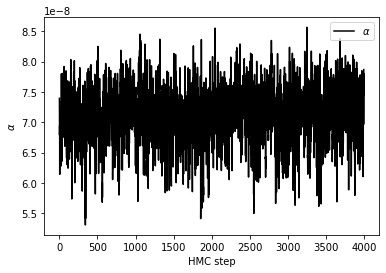

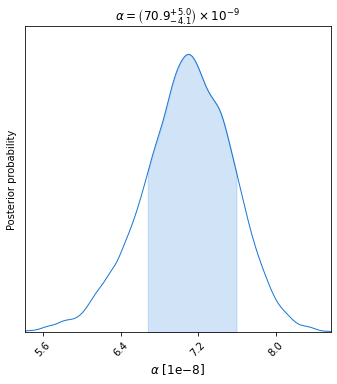

In [13]:
plt.xlabel('HMC step')
plt.ylabel('$\u03B1$')
plt.plot(fit_p2.alpha, c = 'black', label = '$\u03B1$')
plt.legend(loc = 'upper right')
plt.show()

c = ChainConsumer()
c.add_chain(fit_p2.alpha, parameters=['$\u03B1$']) #remove the burn in
fig = c.plotter.plot(filename="example.png", figsize="column")
plt.ylabel("Posterior probability")
plt.show()

The biased detector is most probably the detector labeled "B" with an infered bias of $b = 4.35^{+0.77}_{-0.63} g$. This is consistent with my expectation from the plot of the data. This is a considerable bias which should and does effect the inferance of the decay rate, the new value is thus $\alpha = 69.5^{+6.3}_{-2.7} \times 10^{-9}   s^{-1}$, which corresponds to a half-life of about $T_{1/2} = 115.4$ days. The isotope is likely to be either fermium-257  	($T_{1/2} = 100.5$) or thulium-170 ($T_{1/2} = 128.6$).

# Question 2 


We are given the brightness of the star as a function of time, where we can see quasi-periodic signal in the data due to stellar rotaion. I will assume time is measured in days.

In [14]:
import pickle
with open("assignment2_gp.pkl", "rb") as fp:
    data = pickle.load(fp)

In [15]:
t = data['t']
y = data['y']
yerr = data['yerr']

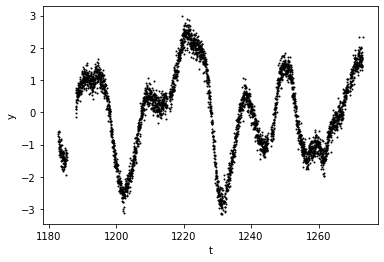

In [16]:
plt.scatter(t,y, s = 1, c = 'black')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

# Part 1
Report on any periodicity in the data. 
To achieve this we do a Fourier transform, however since some of the data is missing we need to use a Lomb-Scargle periodogram.

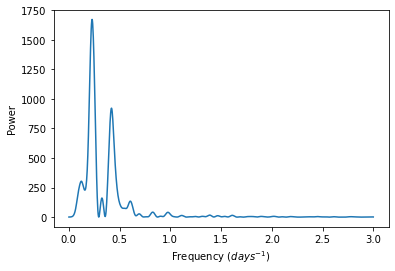

In [17]:
from scipy.signal import lombscargle

# define frequency domain
f = np.linspace (0.001 , 3 , 1000)
#get periodogram
pgram = lombscargle(t , y , f )

plt.plot(f, pgram)
plt.xlabel('Frequency ($days^{-1}$)')
plt.ylabel('Power')
plt.show()



In [18]:
#  find the value of the peaks
from scipy.signal import find_peaks


#This gives me the index of the peaks
peaks, _ = find_peaks(pgram)

peak_freq = []
peak_power = []
for peak in peaks:
    #set threshold on the peak powers
    if pgram[peak] > 50:
        peak_freq.append(f[peak])
        peak_power.append(pgram[peak]) 

peak_period =  2*np.pi/np.array(peak_freq)     
print(peak_freq);
print(peak_power);
print(peak_period)

[0.12408208208208209, 0.22915215215215215, 0.3252162162162162, 0.4212802802802803, 0.5443623623623624, 0.6044024024024024]
[303.7338535531477, 1672.5293349002325, 161.22034551745273, 921.9943875207888, 75.13156190410729, 134.66866140779103]
[50.63732976 27.41927251 19.32002463 14.91450135 11.54228459 10.39569876]



| Peak Number | Peak Frequency (days$^{-1}$) | Peak Period (days)  | Peak Power |
|-------------|----------------|--------------|------------|
| 1           |     0.124      |      50.6        |    303.7       |
| 2           |     0.229      |      27.4        |    1672.5      |
| 3           |     0.325      |      19.3        |    161.22      |
| 4           |     0.421      |      14.9        |    922.0       |
| 5           |     0.5        |      11.5        |    75.1        |
| 6           |     0.604      |      10.4        |    134.7       |


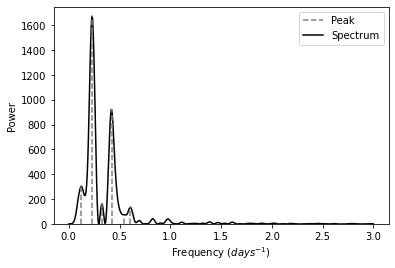

In [19]:
plt.plot(f, pgram, c ='k')
plt.xlabel('Frequency ($days^{-1}$)')
plt.ylabel('Power')
plt.ylim(0,1750)
for i in range(len(peak_power)):
    plt.axvline(x=peak_freq[i], ymin = 0,ymax = peak_power[i]/1750, color='grey', linestyle='--')



legend_elements = [
    Line2D([], [], color='grey', linestyle='--', label='Peak'),
    Line2D([], [], color='k', linestyle='-', label='Spectrum')
]
plt.legend(handles=legend_elements)
plt.show()



The two main peaks that dominate the periodogram have corresponding periods of 27.4 and 14.9 days. 

### Part 2 

Use a Gaussian process to fit these data (or some justified subset thereof) and make predictions for
the future brightness of this star for two months after the last data point. Remember to specify the
kernel choice, and all other relevant bits of information.

The choice of a kernel is crucial when implementing a gaussian processes. Because we know the data is periodic by nature it follows that a periodic kernel should be untilised to describe this pattern in the data. It is also crucial to use the RBF (Radial Basis Function) kernel because it can capture complex and non-linear relationships between data points and thus take into acount any other physical processes that effects the brightness of the star (although on the dynamical timescale im not sure many processes would). 

The RBF kernel is defined as:
$$
k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left ( -\frac{(x_i-x_j)^2}{2} \right )
$$

While the periodic kernel is:
$$
k(\mathbf{x}_i,\,\mathbf{x}_j) =
    \exp \left( -\Gamma\,\sin^2\left[
        \frac{\pi}{P}\,\left|x_i-x_j\right|
    \right] \right)
$$

Here I have the choice as to how many periodicities I choose to incorporate into my model, due to the fear of overfitting I will only model the two most dominant periods. My overall kernel will be the sum of the three mentioned.

My kernel will therefore be, 

$$
k(r) = k_1(r) + k_2(r) + k_3(r)
$$

where,

$$
k_1(r) = \theta_1^2\exp\left(-\frac{(r)^2}{2\theta_2}\right)
$$

$$
k_2(r) = \theta_3^2\exp\left(-\Gamma_1\sin^2(\pi|r|/p_1)\right)
$$

$$
k_3(r) = \theta_4^2\exp\left(-\Gamma_2\sin^2(\pi|r|/p_2)\right)
$$


Here $r = x_i - x_j$ and $p_1$ and $p_2$ are the dominant periods in the periodogram. $\Gamma$ and $\theta$ are hyperparameters that will need to be optimised for. 



In [20]:
import george
from george import kernels

In [21]:
#define kernels
#play around with initial hyperparameters, this should also help with optimisation. 
k1 = 1**2 * kernels.ExpSquaredKernel(metric = 5**2)
k2 = 1**2 * kernels.ExpSine2Kernel ( gamma = 1**2 , log_period = np.log(peak_period[1]))
k3 = 1**2 *kernels.ExpSine2Kernel ( gamma = 1**2 , log_period = np.log(peak_period[3]))

#combine
kernel = k1 + k2 + k3
#compute the guassian process
gp = george.GP(kernel)
gp.compute(t,yerr)

#prepare a prediction plot for 2 months later 
t_pred = np.linspace(max(t),max(t)+ 62, 1000)

mu, var = gp.predict(y, t_pred, return_var=True)
std = np.sqrt(var)



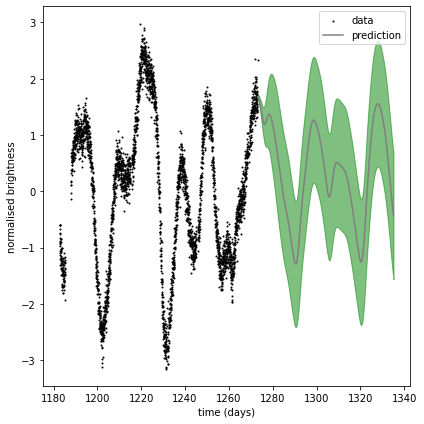

In [23]:
#plot initial results
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(t, y, s=1, c="k", label = 'data')
ax.fill_between(t_pred, mu+std, mu-std, color="g", alpha=0.5)
ax.plot(t_pred, mu, c = 'grey', label = 'prediction')        
ax.set_xlabel(r"time (days)")
ax.set_ylabel(r"normalised brightness")
ax.legend()
fig.tight_layout()

Now lets optimise for the hyper parameters. 

In [24]:
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25


def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

gp.set_parameter_vector(results.x)
mu , var = gp . predict (y , t_pred , return_var = True )
print(gp.log_likelihood(y))

637.3831060300963


The expected brightness of the star after 2 months is: -0.013 +/- 1.127


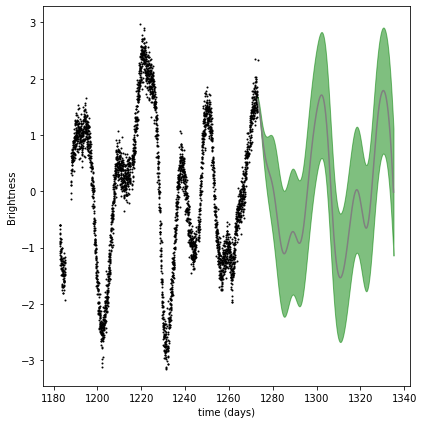

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(t, y, s=1, c="k", label = 'data')
ax.fill_between(t_pred, mu+std, mu-std, color="g", alpha=0.5)
ax.plot(t_pred, mu, c = 'grey', label = 'prediction')        
ax.set_xlabel(r"time (days)")
ax.set_ylabel(r"normalised Brightness")
ax.legend()
fig.tight_layout()


print('The expected brightness of the star after 2 months is: {:.3f} +/- {:.3f}'.format(mu[-1], std[-1]))


This looks good but I wonder if I can improve this model. I notice that in the notes, you multiply the RBF and periodic kernels. By multiplying them together I am essentially combining thier properties, the local dependancies from the RBF kernel and the periodicicity from the periodic kernel. So lets try that!

In [26]:
#define kernels
#had to play around with the initial hyperparameters to get something close. 
k1 = 1**2*kernels.ExpSquaredKernel(metric = 1000)
k2 = 2**2*kernels.ExpSine2Kernel(gamma = 5 , log_period = np.log(peak_period[1]))
k3 = 1**2*kernels.ExpSine2Kernel(gamma = 1 , log_period = np.log(peak_period[3]))

kernel = k1*(k2 + k3)

#compute the guassian process
gp = george.GP(kernel)
gp.compute(t,yerr)
mu, var = gp.predict(y, t_pred, return_var=True)
std = np.sqrt(var)

The expected brightness of the star after 2 months is: 2.3338229677627442


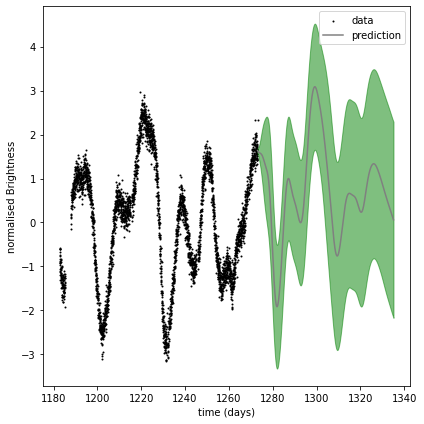

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(t, y, s=1, c="k", label = 'data')
ax.fill_between(t_pred, mu+std, mu-std, color="g", alpha=0.5)
ax.plot(t_pred, mu, c = 'grey', label = 'prediction')        
ax.set_xlabel(r"time (days)")
ax.set_ylabel(r"normalised Brightness")
ax.legend()
fig.tight_layout()
print('The expected brightness of the star after 2 months is:', y[-1])

In [28]:
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

gp.set_parameter_vector(results.x)
mu , var = gp . predict (y , t_pred , return_var = True )
print(gp.log_likelihood(y))

671.5908835487653


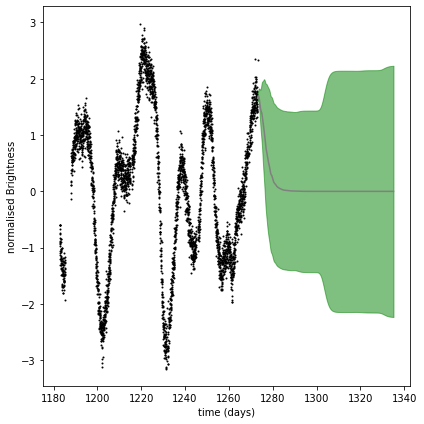

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(t, y, s=1, c="k")
ax.fill_between(t_pred, mu+std, mu-std, color="g", alpha=0.5)
ax.plot(t_pred, mu, c = 'grey')        
ax.set_xlabel(r"time (days)")
ax.set_ylabel(r"normalised Brightness")
fig.tight_layout()

![Image](what_the.jpg)

Although this change of kernel yeilded a larger likelihood it looks like the optimisation failed and converged on a local minimum. I could play around with the initial conditions but the optimisation is taking too long. Therefore I would report the original solution as my answer.

## Question 4
We have a dataset of 17,736 colour images of galaxies. 
There are 10 classes of galaxies contained in these images.

Train five classifiers (different techniques) to classify galaxies. You can choose these techniques, but
you should choose them to be appropriate for the problem and suitable to give good results on this
data set. Ensure that you split your data set appropriately to train, validation (where appropriate),
and test.
Evaluate these classification techniques and make a recommendation for which is most suitable. As
part of evaluating performance, you should consider and discuss things like precision, recall,
confusion matrices, biased/unbiased training sets, and cross-validation.

In [ ]:
# It killed my kernel I dont have enough ram I will have to do question 5 :( ?!?
import h5py
import numpy as np
from tensorflow.keras import utils
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    # To convert the labels to categorical 10 classes
    labels = utils.to_categorical(labels, 10)
    # To convert to desirable type
    labels = labels.astype(np.float32)
    images = images.astype(np.float32)

## Question 5
We are given real world data, our task is to clean it, infer any behaviours and make a prediction for future data. 
We dont know much about the data but we can expect that some of it is missing, incorrect (outliers) and at times the data changes in behavior.

In [22]:
data = pd.read_csv('unknown_data_cleaned.csv')
data

,Start,End
0,2021-10-05 13:30,2021-10-05 13:51
1,2021-10-05 09:58,2021-10-05 11:07
2,2021-10-05 05:26,2021-10-05 07:08
3,2021-10-05 03:36,2021-10-05 04:32
4,2021-10-05 00:22,2021-10-05 03:02
...,...,...
2135,2021-02-02 22:33,2021-02-03 00:17
2136,2021-02-02 20:31,2021-02-02 21:16
2137,2021-02-02 13:18,2021-02-02 17:42
2138,2021-02-02 09:54,2021-02-02 10:55


The data apears to be the start and end of something with a date and a time in hours and minutes. Lets first convert this into something we can manipulate by getting the Unix timestamp (the time in seconds since Jan 1 1970). The data also seems to be complete without any missing values.

In [23]:
from datetime import datetime

# Convert the string to a datetime object
start = []
end = []
for i in range(len(data['Start'])):
    start_time = datetime.strptime(data['Start'][i], '%Y-%m-%d %H:%M')
    start.append(int(start_time.timestamp()))
    end_time = datetime.strptime(data['End'][i], '%Y-%m-%d %H:%M')
    end.append(int(end_time.timestamp()))

start = np.array(start)
end = np.array(end)

#now lets 0 the data such that t=0 for the data 2021-02-01 22:02 and convert to hours 
start_min = min(start)

start_h = (start - start_min)/3600
end_h = (end - start_min)/3600

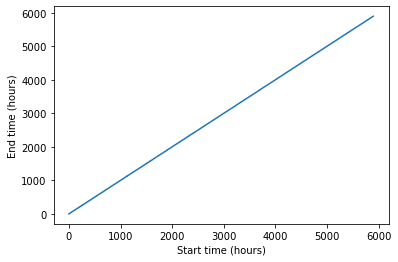

In [24]:
#make a basic plot of the data 
y_to_s = 365 * 24 * 60 * 60 
plt.plot(start_h,end_h)
plt.xlabel('Start time (hours)')
plt.ylabel('End time (hours)')
plt.show()

This doesnt look too interesting I suspect that the information is in how long the process took, so lets plot that!
I will also note that the data is in reverse chronological order (the latest measurement is recorded first).

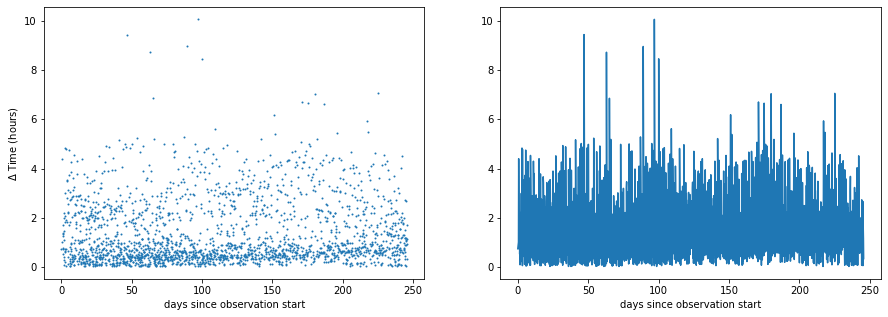

In [25]:
dt = end_h-start_h
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].scatter(start_h/24, dt, s = 1)
ax[0].set_ylabel('$\Delta$ Time (hours)')
ax[0].set_xlabel('days since observation start')
ax[1].plot(start_h/24, dt)
ax[1].set_xlabel('days since observation start')
plt.show()

This looks more promising and depending on how the data is presented, we can mislead ourselves into recognising the paterns that we want. For example in the scatterplot we see that alot of the processes occured on a relatively short timescale and bunches up. Since the data is gather over a period of about 8 months, I belive that there might be a seasonal effect on the data. 

It seems that there could be 2 main sources of the data as well as potential outliers. Whereas in the plot It would apear that the data follows some sort of sinisoidal plot. It also looks like the data is unevenly sampled.

Another interesting feature is the bottom right corner were is seems like the concentrated data seems to diffuse.

Lets make a bar graph to see how the data is distributed. 


In [26]:
ndays = round(max(start_h/24))
print(ndays)

246


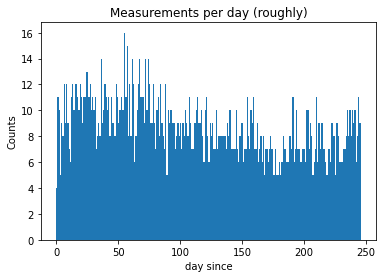

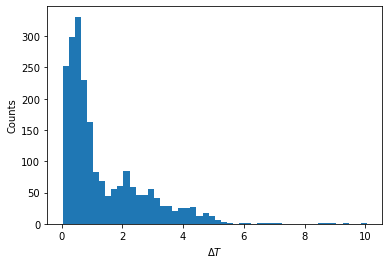

In [27]:
plt.title('Measurements per day (roughly)')
plt.hist(start_h/24, bins=ndays)
plt.xlabel('day since')
plt.ylabel('Counts')
plt.show()

plt.xlabel('$\Delta T$')
plt.ylabel('Counts')
plt.hist(dt, bins = 50)
plt.show()

Im really glad I though to plot the distributions when I was about to go to sleep last night. Not only does it show that the data was unevenly sampled over time but more importantly it clearly shows that there are two processes giving rise to the measurements with the exisitance of potential outliers as well.

In my mind I have two ways I could potentially model this data. 

- Since it is implied that it could change in behaviour over time I should bin the data into days. I would then assume that the data is draw from 2 different processs each causeing a longer or shorter time difference and model that with a guassian. This would envoke a mixture of models for which I would also include a 3rd model that would take into account potential outliers.I could them obsever how the parameters of that model changes with time and therefore be able to point out when the data changes in behavior (I.e mean value, and variance, conditional propabilities ect). I could then fit for those parameters to obtain a prediction for the future. This seems like the right approach since 'outliers' apear more common in the second quater, but it might proove too challenging.  



- The other idea I had in mind would be to use a mixture of models where the data is drawn from 2 straight lines and potential outliers are drawn from a guassian with high variance. Although this would be hopefully more straightforward to model it may not be able to take into account how the trend changes with time. 

In [28]:
#lets bin the data

#convert hours to days
start_d= start_h/24

num_days = int(max(start_d) - min(start_d)) + 1

#I will bin the data in days first maybe increase it to a month or 3 days 
bin_edges = np.linspace(0, 246, int(247/7))

# Bin dt data based on the day values
bins = np.digitize(start_d, bin_edges)

# Create a dictionary to store the binned data
binned_data = {}

# Iterate over the bins and dt values
for b, y_val in zip(bins, dt):
    if b not in binned_data:
        binned_data[b] = []
    binned_data[b].append(y_val)

#Convert the dictionary into an array    
array_data = list(binned_data.values())    

In [29]:
len(array_data)

34

I have to be careful with the bin sizes, since if they were too narrow, I might not have enough data points to model the different processes, and if they were too large then I would loose information on how the processes change with time. I settled to group the data into weeks thus giving a resonable amount of points to fit to while maintianing a decent resolution on the changeing behaviour of the data

The following plots show snippets snipets of the data when they have been binned into weeks, we can see how there are 2 main 'bunching' one with a lower mean and variance compared to the other and appears more commonly. Whereas in some weeks you can see the outliers comming through. 

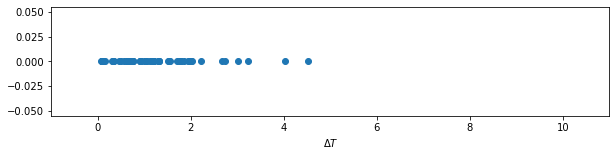

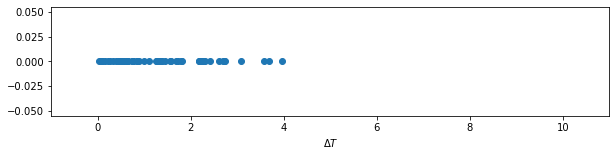

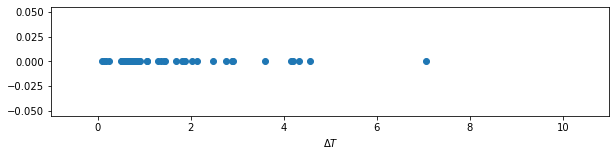

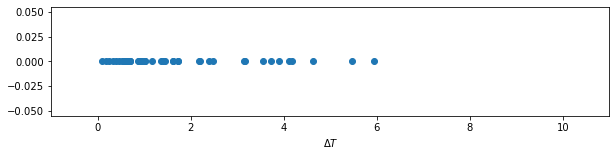

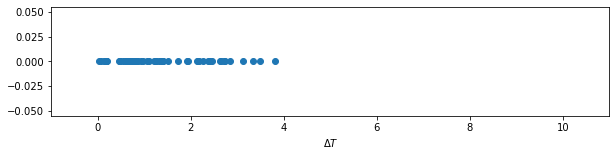

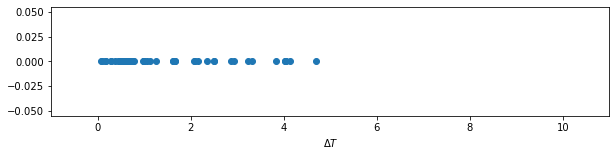

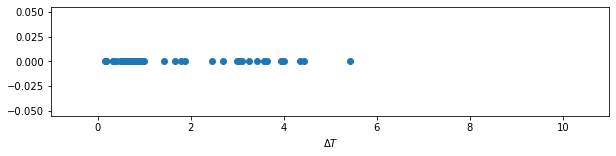

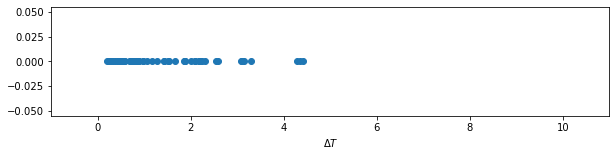

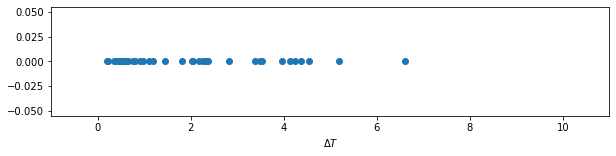

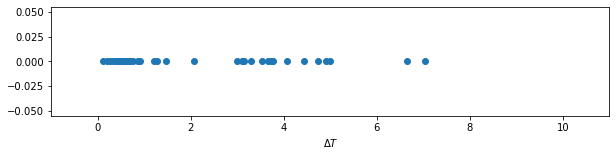

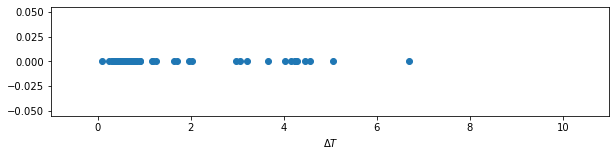

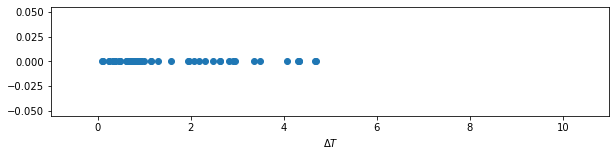

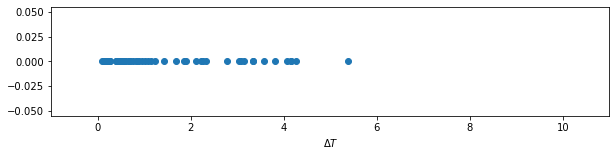

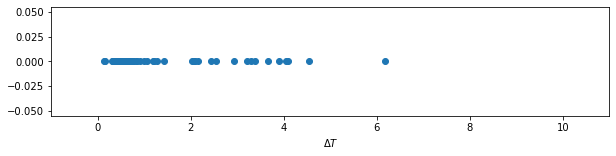

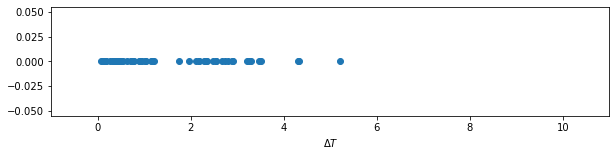

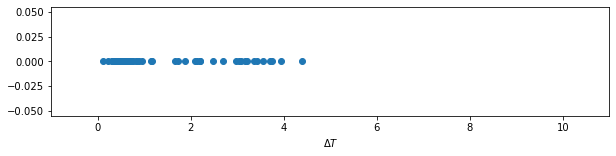

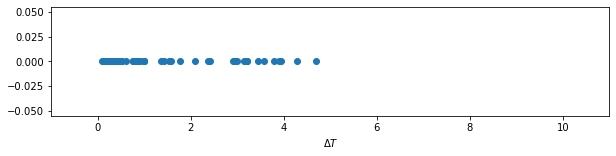

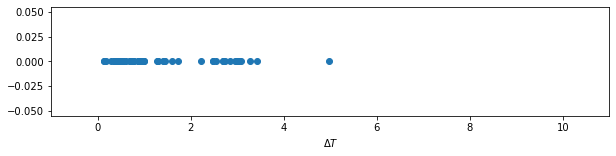

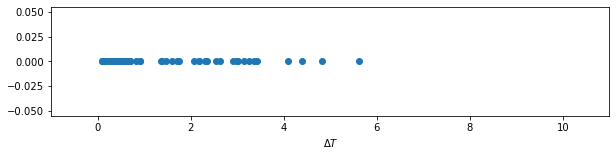

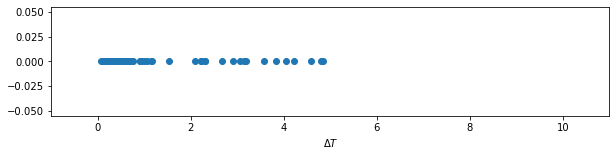

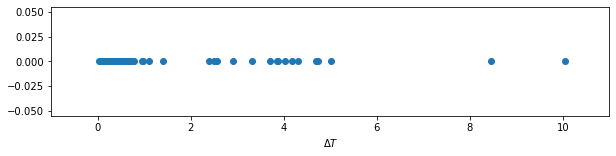

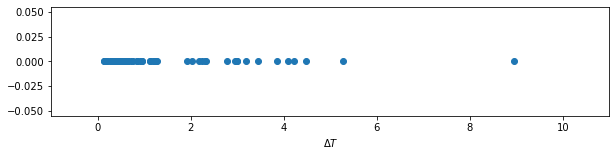

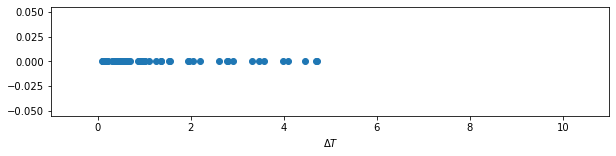

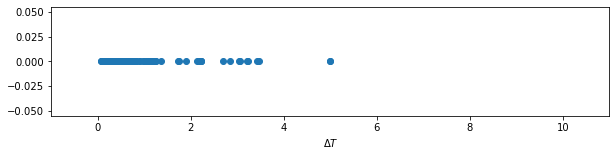

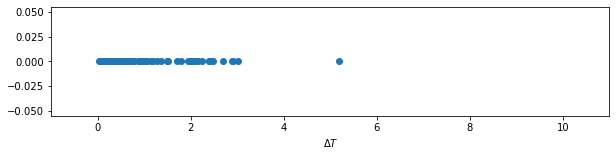

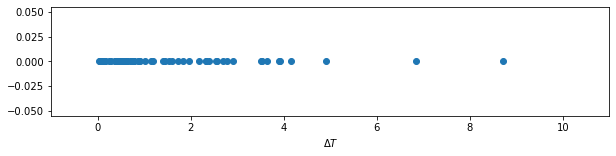

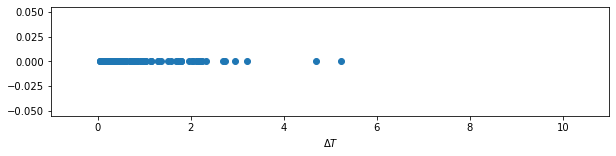

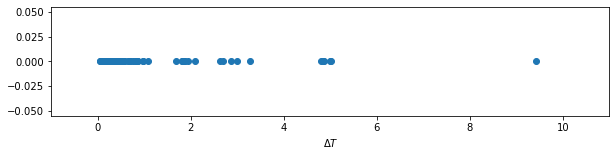

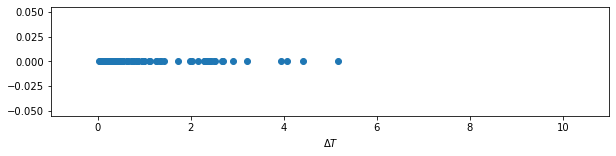

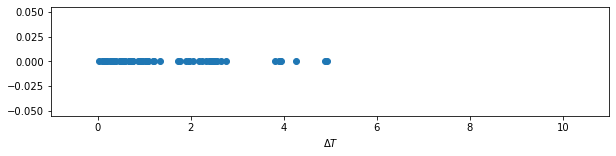

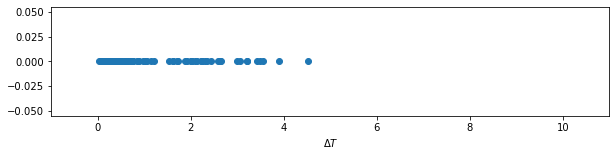

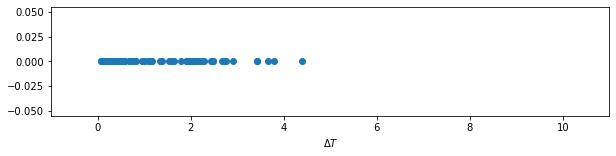

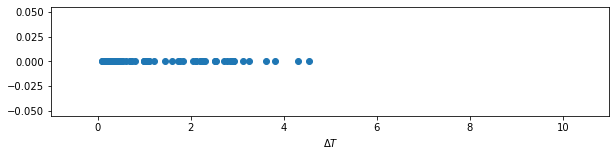

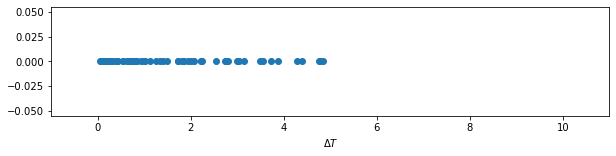

In [30]:
for array in array_data:
    fig, ax = plt.subplots(1,1, figsize = (10,2))
    # Set the y-axis to a constant value
    y = [0] * len(array)
    # Plot the data
    ax.scatter(array, y)

    # Set the x-axis label
    ax.set_xlabel('$\Delta T$')
    ax.set_xlim(-1,11)
    # Show the plot
    plt.show()

In [31]:
text = '''data {
    // number of datapoints
    int<lower=0> N;  
    // data
    vector[N] dt;
}
parameters {
    // memberships
    simplex[3] pi; 
    // means of the Gaussians
    // using ordered forces the means to increase
    ordered[3] mu;   
    // standard deviations of Gaussians
    vector<lower=0>[3] sigma; 
}
model {
  vector[3] log_pi = log(pi);  
  
  // priors
  pi ~ dirichlet(rep_vector(2, 3)); 
  mu ~ normal(0, 15);
  sigma ~ cauchy(0, 2.5);

  // likelihood
  for (n in 1:N) {
    vector[3] lps = log_pi;
    for (k in 1:3) {
      lps[k] += normal_lpdf(dt[n] | mu[k], sigma[k]);
    }
    target += log_sum_exp(lps);
  }
}
'''

file_path = "A1Q5.stan"

# Open the file in write mode and write the text
with open(file_path, "w") as file:
    file.write(text)

In [32]:
model = CmdStanModel(stan_file='A1Q5.stan')

# Data.
data = dict(
    N = len(array_data[0]),
    dt = array_data[0],
)


fit = model.sample(data = data)


16:11:21 - cmdstanpy - INFO - compiling stan file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q5.stan to exe file /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q5
16:11:35 - cmdstanpy - INFO - compiled model executable: /home/lewis/Documents/Honours/Machine learning/notebooks/Assignment1/A1Q5
16:11:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:11:38 - cmdstanpy - INFO - CmdStan done processing.
16:11:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpw9igqnu9/tmpp0quhkrl.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpw9igqnu9/tmpp0quhkrl.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:11:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 28 divergent transitions (2.8%)
	Use function "diagnose()" to see further information.


Lets check the results with some plots.

In [33]:
def gauss(x, mu, sigma): 
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

mu = fit.mu.T
sigma = fit.sigma.T
pi = fit.pi.T

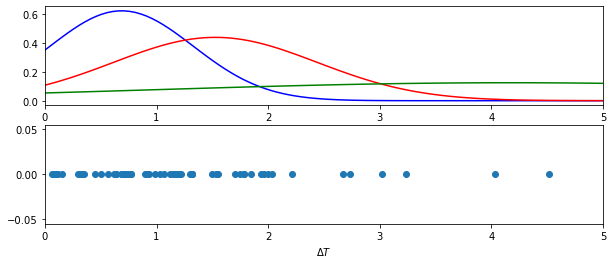

In [34]:
fig, ax = plt.subplots(2,1, figsize = (10,4))
# Generate x values
x = np.linspace(0,5, 100)
tmp = [0] * len(array_data[0])

# Plot the Gaussian distribution
ax[0].plot(x, gauss(x,np.mean(mu[0][2000:]),np.mean(sigma[0][2000:])), color='blue', label='Gaussian Distribution')
ax[0].plot(x, gauss(x,np.mean(mu[1][2000:]),np.mean(sigma[1][2000:])), color='r', label='Gaussian Distribution')
ax[0].plot(x, gauss(x,np.mean(mu[2][2000:]),np.mean(sigma[2][2000:])), color='g', label='Gaussian Distribution')
ax[0].set_xlim(0,5)
ax[1].set_xlim(0,5)
ax[1].scatter(array_data[0],tmp)
ax[1].set_xlabel('$\Delta T$')
plt.show()

This model looks like it it working as desired, lets loop it over the entire data set and record the parameters.

In [35]:
model = CmdStanModel(stan_file='Chat.stan')

pi_list = []
mu_list = []
sigma_list = []
u_pi_list = []
u_mu_list = []
u_sigma_list = []
for i, array in enumerate(array_data):
    print(i)
    data = dict(
        N = len(array),
        dt = array,
    )


    fit = model.sample(data = data)
    
    pi = np.mean(fit.pi[2000:], axis = 0)
    mu = np.mean(fit.mu[2000:], axis = 0)
    sigma = np.mean(fit.sigma[2000:], axis = 0)
    u_pi = np.std(fit.pi[2000:], axis = 0)
    u_mu = np.std(fit.mu[2000:], axis = 0)
    u_sigma = np.std(fit.sigma[2000:], axis = 0)
    
    
    pi_list.append(pi)
    mu_list.append(mu)
    sigma_list.append(sigma)
    u_pi_list.append(u_pi)
    u_mu_list.append(u_mu)
    u_sigma_list.append(u_sigma)

16:11:39 - cmdstanpy - INFO - CmdStan start processing


0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:11:45 - cmdstanpy - INFO - CmdStan done processing.
16:11:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:11:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 10 divergent transitions (1.0%)
	Use function "diagnose()" to see further information.
16:11:45 - cmdstanpy - INFO - CmdStan start processing



1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:11:56 - cmdstanpy - INFO - CmdStan done processing.
16:11:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:11:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:11:56 - cmdstanpy - INFO - CmdStan start processing



2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:11:58 - cmdstanpy - INFO - CmdStan done processing.
16:11:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:11:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:11:58 - cmdstanpy - INFO - CmdStan start processing



3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:00 - cmdstanpy - INFO - CmdStan done processing.
16:12:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:12:00 - cmdstanpy - INFO - CmdStan start processing



4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:09 - cmdstanpy - INFO - CmdStan done processing.
16:12:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
16:12:09 - cmdstanpy - INFO - CmdStan start processing



5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:13 - cmdstanpy - INFO - CmdStan done processing.
16:12:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
16:12:13 - cmdstanpy - INFO - CmdStan start processing



6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:17 - cmdstanpy - INFO - CmdStan done processing.
16:12:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.
16:12:17 - cmdstanpy - INFO - CmdStan start processing



7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:19 - cmdstanpy - INFO - CmdStan done processing.
16:12:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:12:19 - cmdstanpy - INFO - CmdStan start processing



8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:22 - cmdstanpy - INFO - CmdStan done processing.
16:12:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
16:12:22 - cmdstanpy - INFO - CmdStan start processing



9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:24 - cmdstanpy - INFO - CmdStan done processing.
16:12:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.
16:12:24 - cmdstanpy - INFO - CmdStan start processing



10


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:53 - cmdstanpy - INFO - CmdStan done processing.
16:12:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 775 iterations at max treedepth (77.5%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:12:53 - cmdstanpy - INFO - CmdStan start processing



11


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:58 - cmdstanpy - INFO - CmdStan done processing.
16:12:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:12:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.
16:12:58 - cmdstanpy - INFO - CmdStan start processing



12


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:02 - cmdstanpy - INFO - CmdStan done processing.
16:13:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.
16:13:02 - cmdstanpy - INFO - CmdStan start processing



13


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:04 - cmdstanpy - INFO - CmdStan done processing.
16:13:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:04 - cmdstanpy - INFO - CmdStan start processing



14


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:07 - cmdstanpy - INFO - CmdStan done processing.
16:13:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.
16:13:07 - cmdstanpy - INFO - CmdStan start processing



15


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:10 - cmdstanpy - INFO - CmdStan done processing.
16:13:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.
16:13:11 - cmdstanpy - INFO - CmdStan start processing



16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:13 - cmdstanpy - INFO - CmdStan done processing.
16:13:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:13 - cmdstanpy - INFO - CmdStan start processing



17


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:17 - cmdstanpy - INFO - CmdStan done processing.
16:13:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.
16:13:17 - cmdstanpy - INFO - CmdStan start processing



18


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:19 - cmdstanpy - INFO - CmdStan done processing.
16:13:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:19 - cmdstanpy - INFO - CmdStan start processing



19


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:21 - cmdstanpy - INFO - CmdStan done processing.
16:13:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 74 divergent transitions (7.4%)
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:22 - cmdstanpy - INFO - CmdStan start processing



20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:29 - cmdstanpy - INFO - CmdStan done processing.
16:13:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:30 - cmdstanpy - INFO - CmdStan start processing



21


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:38 - cmdstanpy - INFO - CmdStan done processing.
16:13:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
16:13:38 - cmdstanpy - INFO - CmdStan start processing



22


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:42 - cmdstanpy - INFO - CmdStan done processing.
16:13:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:42 - cmdstanpy - INFO - CmdStan start processing



23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:44 - cmdstanpy - INFO - CmdStan done processing.
16:13:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:44 - cmdstanpy - INFO - CmdStan start processing



24


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:47 - cmdstanpy - INFO - CmdStan done processing.
16:13:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:47 - cmdstanpy - INFO - CmdStan start processing



25


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:51 - cmdstanpy - INFO - CmdStan done processing.
16:13:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:51 - cmdstanpy - INFO - CmdStan start processing



26


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:53 - cmdstanpy - INFO - CmdStan done processing.
16:13:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.
16:13:53 - cmdstanpy - INFO - CmdStan start processing



27


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:56 - cmdstanpy - INFO - CmdStan done processing.
16:13:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:56 - cmdstanpy - INFO - CmdStan start processing



28


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:58 - cmdstanpy - INFO - CmdStan done processing.
16:13:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:13:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:13:58 - cmdstanpy - INFO - CmdStan start processing



29


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:01 - cmdstanpy - INFO - CmdStan done processing.
16:14:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:14:01 - cmdstanpy - INFO - CmdStan start processing



30


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:03 - cmdstanpy - INFO - CmdStan done processing.
16:14:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:14:03 - cmdstanpy - INFO - CmdStan start processing



31


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:06 - cmdstanpy - INFO - CmdStan done processing.
16:14:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:14:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:14:07 - cmdstanpy - INFO - CmdStan start processing



32


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:10 - cmdstanpy - INFO - CmdStan done processing.
16:14:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!
16:14:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
16:14:10 - cmdstanpy - INFO - CmdStan start processing



33


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:12 - cmdstanpy - INFO - CmdStan done processing.
16:14:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/tmpx9s33q9r/tmpy1jwhp1l.stan', line 28, column 6 to column 53)
Consider re-running with show_console=True if the above output is unclear!


Lets visualise the results

In [36]:
pi1 = []
pi2 = []
pi3 = []
for arr in pi_list:
    pi1.append(arr[0])
    pi2.append(arr[1])
    pi3.append(arr[2])
    
u_pi1 = []
u_pi2 = []
u_pi3 = []
for arr in u_pi_list:
    u_pi1.append(arr[0])
    u_pi2.append(arr[1])
    u_pi3.append(arr[2])   
    
mu1 = []
mu2 = []
mu3 = []
for arr in mu_list:
    mu1.append(arr[0])
    mu2.append(arr[1])
    mu3.append(arr[2])
    
u_mu1 = []
u_mu2 = []
u_mu3 = []
for arr in u_mu_list:
    u_mu1.append(arr[0])
    u_mu2.append(arr[1])
    u_mu3.append(arr[2])          
    
s1 = []
s2 = []
s3 = []
for arr in sigma_list:
    s1.append(arr[0])
    s2.append(arr[1])
    s3.append(arr[2])
    
u_s1 = []
u_s2 = []
u_s3 = []
for arr in u_sigma_list:
    u_s1.append(arr[0])
    u_s2.append(arr[1])
    u_s3.append(arr[2])
    
x = np.arange(0,len(pi1),1)    


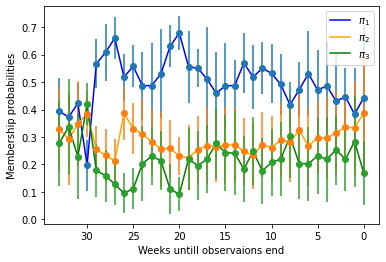

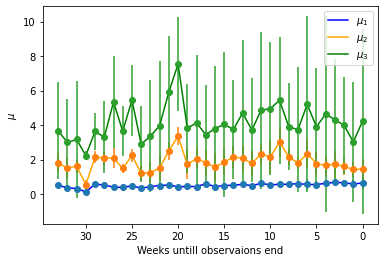

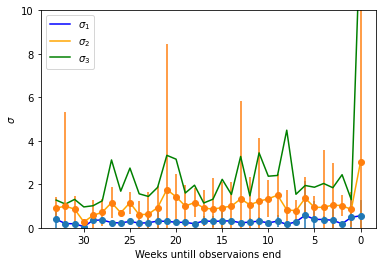

In [37]:
plt.errorbar(x, pi1, yerr=u_pi1, fmt='o')
plt.errorbar(x, pi2, yerr=u_pi2, fmt='o')
plt.errorbar(x, pi3, yerr=u_pi3, fmt='o')
plt.plot(pi1, label = '$\pi_1$', c = 'blue')
plt.plot(pi2,label = '$\pi_2$', c = 'orange')
plt.plot(pi3,label = '$\pi_3$', c = 'green')
plt.legend()
plt.xlabel('Weeks untill observaions end')
plt.ylabel('Membership probabilities')
plt.gca().invert_xaxis()
plt.show()

    
plt.errorbar(x, mu1, yerr=u_mu1, fmt='o')
plt.errorbar(x, mu2, yerr=u_mu2, fmt='o')
plt.errorbar(x, mu3, yerr=u_mu3, fmt='o')
plt.plot(mu1, label = '$\mu_1$', c ='b')
plt.plot(mu2, label = '$\mu_2$', c = 'orange')
plt.plot(mu3,  label = '$\mu_3$', c = 'g')
plt.legend()
plt.xlabel('Weeks untill observaions end')
plt.ylabel('$\mu$')
plt.gca().invert_xaxis()
plt.show()


plt.errorbar(x, s1, yerr=u_s1, fmt='o')
plt.errorbar(x, s2, yerr=u_s2, fmt='o')
# plt.errorbar(x, s3, yerr=u_s3, fmt='o')    #the error bars as one might expect are huge
plt.plot(s1,  label = '$\sigma_1$', c = 'b')
plt.plot(s2,  label = '$\sigma_2$', c = 'orange')
plt.plot(s3,  label = '$\sigma_3$', c = 'g')
plt.legend()
plt.xlabel('Weeks untill observaions end')
plt.ylabel('$\sigma$')
plt.gca().invert_xaxis()
plt.ylim(0,10)
plt.show()

0


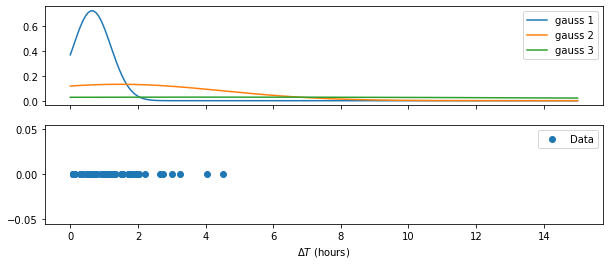

1


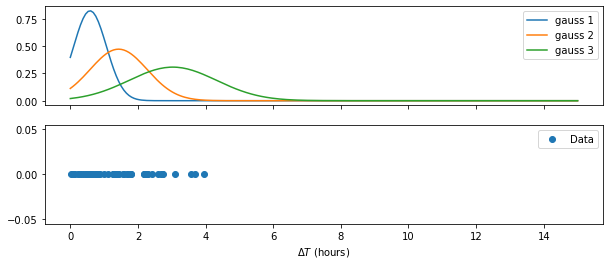

2


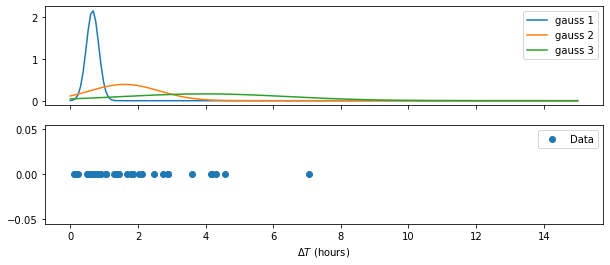

3


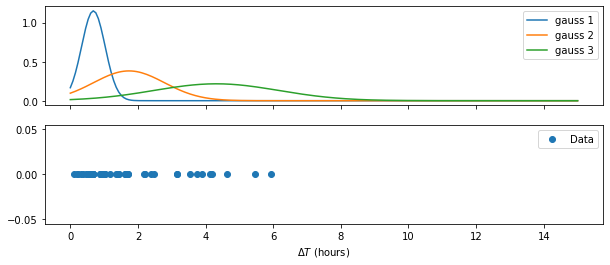

4


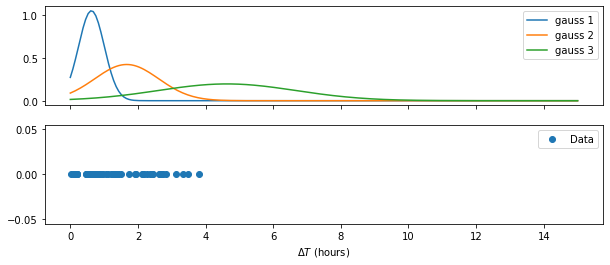

5


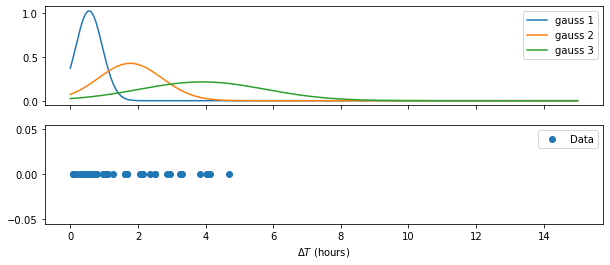

6


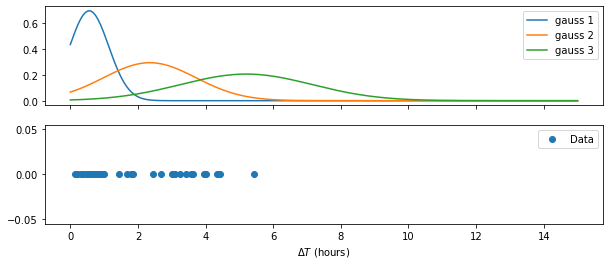

7


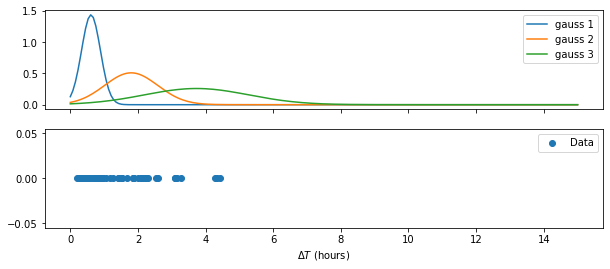

8


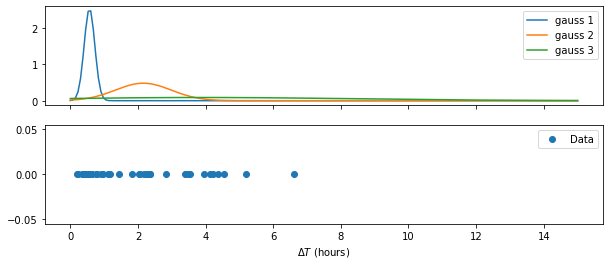

9


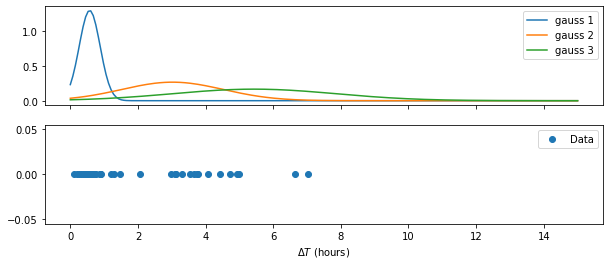

10


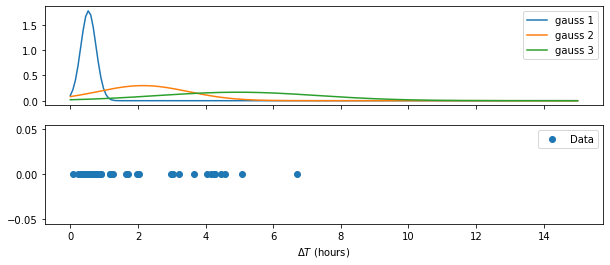

11


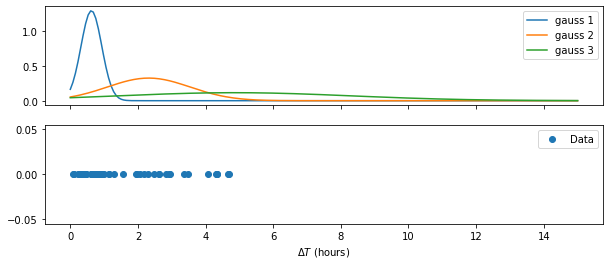

12


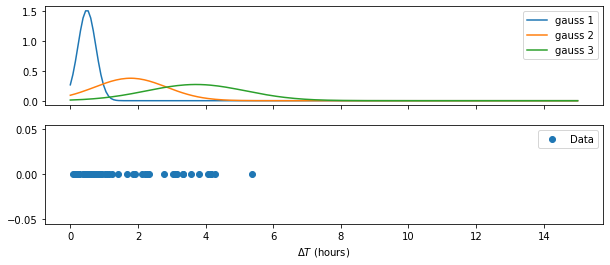

13


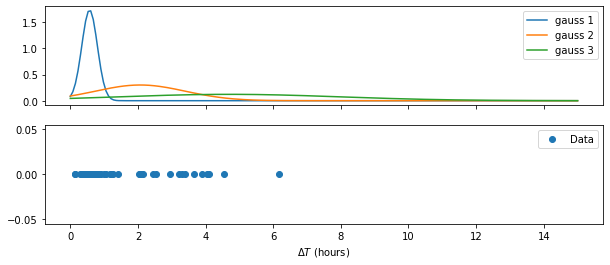

14


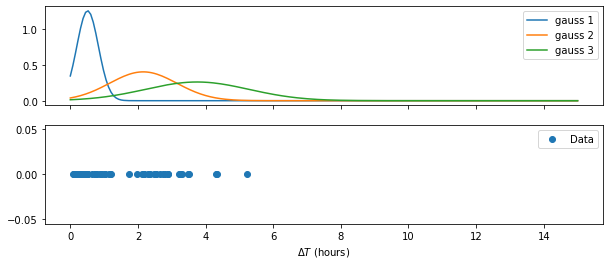

15


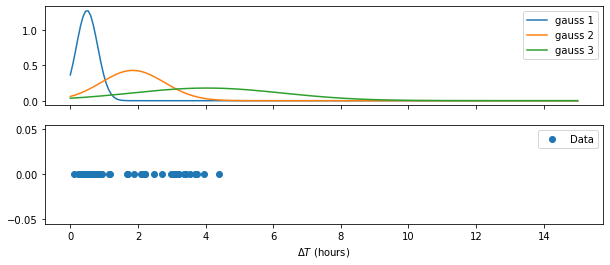

16


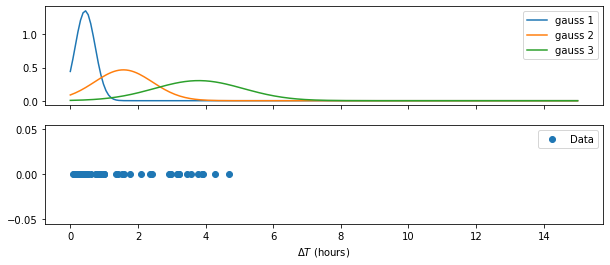

17


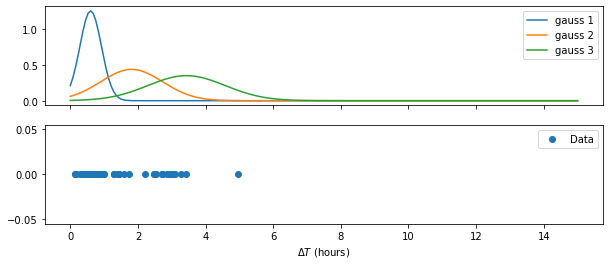

18


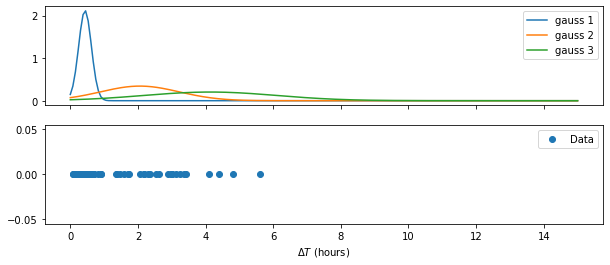

19


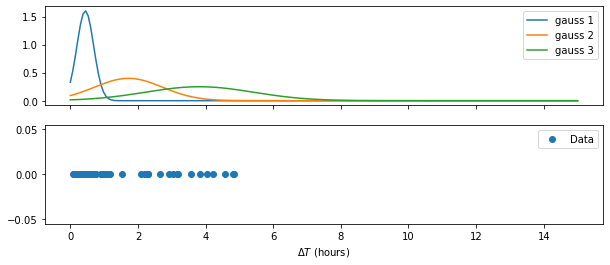

20


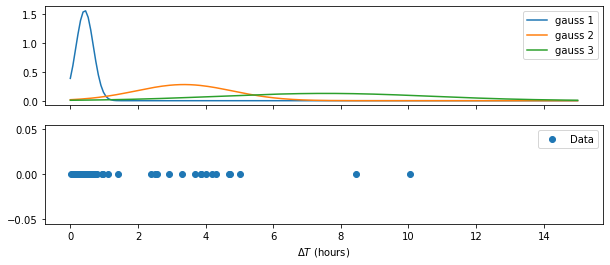

21


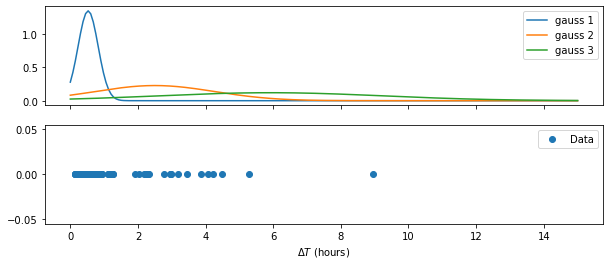

22


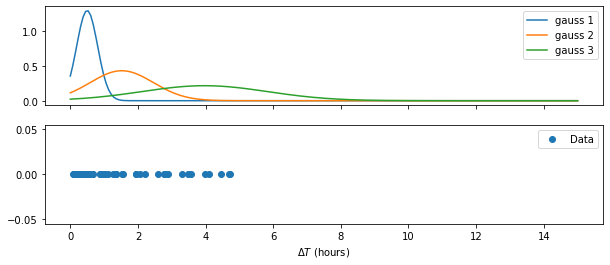

23


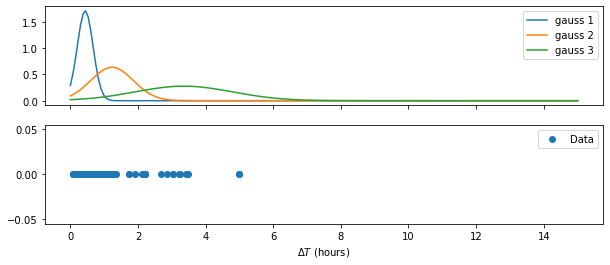

24


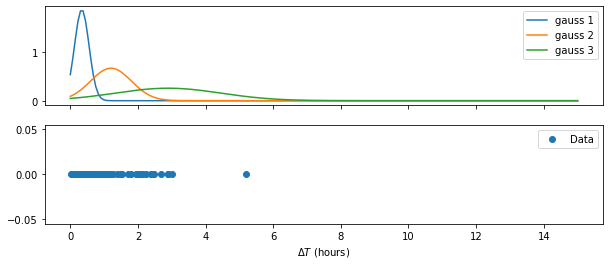

25


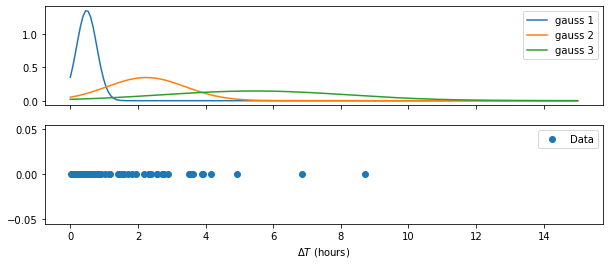

26


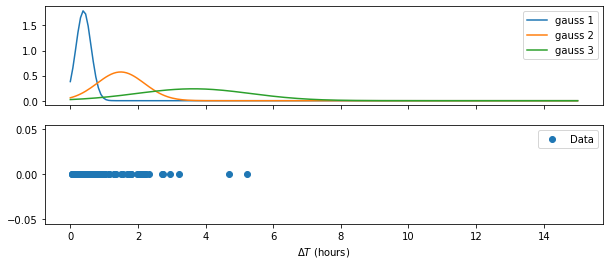

27


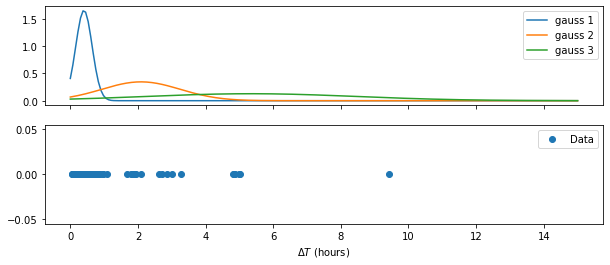

28


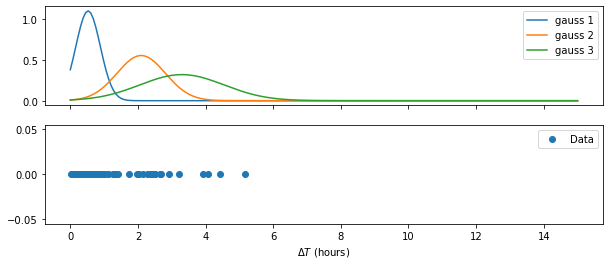

29


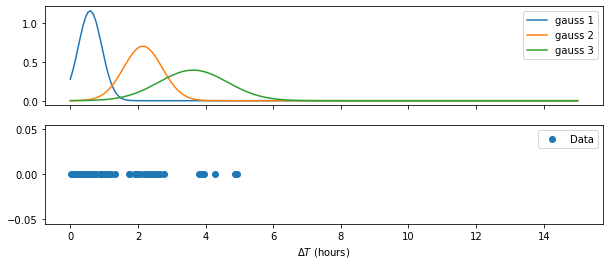

30


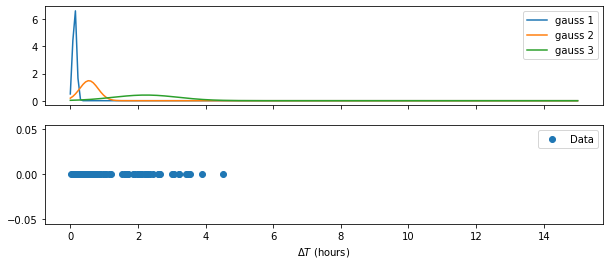

31


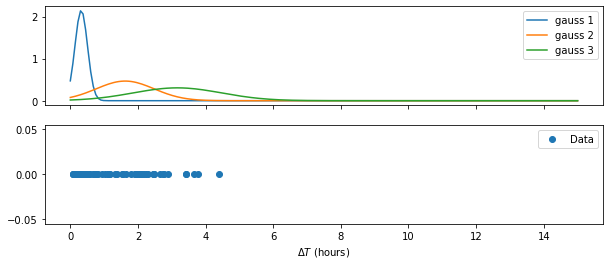

32


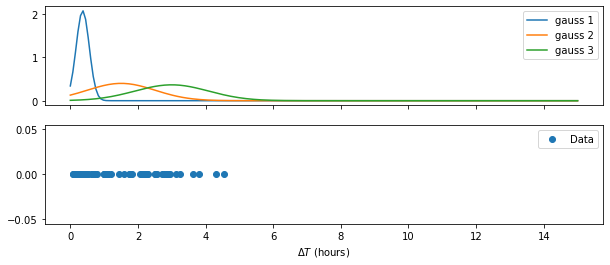

33


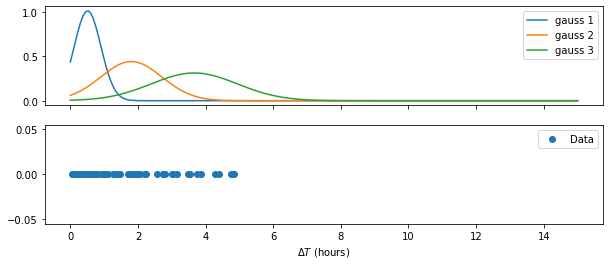

In [38]:
for i, array in enumerate(array_data):
    print(i)
    fig, ax = plt.subplots(2,1, figsize = (10,4),sharex=True)
    # Generate x values
    x = np.linspace(0,15, 200)

    
    # Plot the Gaussian distribution
    ax[0].plot(x, gauss(x,mu1[i],s1[i]), label = 'gauss 1')
    ax[0].plot(x, gauss(x,mu2[i],s2[i]), label='gauss 2')
    ax[0].plot(x, gauss(x,mu3[i],s3[i]), label='gauss 3')
    ax[0].legend()
    tmp = [0] * len(array)
    ax[1].scatter(array,tmp,label = 'Data')
    ax[1].legend()
    ax[1].set_xlabel('$\Delta T$ (hours)')
    plt.show()

Honestly I am a fairly happy with these plots. However I am a bit upset that there isnt any obvious trend to the parameters for me to fit too (but thats real data for ya). Some interesting things to note is that the mean and variance of our outlier model spikes when there there seems to be an obvious outlier. On top of this the memberships probababilities for the first component drops towards the end of observations and the mean value steadily increaseing for the first and maybe for the second component. This implies that the data is difusing. 

The next stage would be to make a future prediction for the data. Originally my idea was to model the parameters with time, and create a future prediction from those parameters. Unfortunatly the plots looks noisy and it probably wont turn out great, but lack of a better idea as mario might say, 'lets-a go'. 

I have decided to fit a straight line to the  $\mu$ and $\sigma$ curves and to fit a quadratic to the membership components, simply because of the way it looks. 

In [39]:
def linear(x,m,b):
    return m*x + b

def quad(x,a,b,c):
    return a * x**2 + b * x +c 

x = np.arange(0,len(pi1),1)  

popt_pi1, pcov_pi1 = op.curve_fit(quad, x, pi1, sigma=u_pi1)
popt_pi2, pcov_pi2 = op.curve_fit(quad, x, pi2, sigma=u_pi2)
popt_pi3, pcov_pi3 = op.curve_fit(quad, x, pi3, sigma=u_pi3)

popt_mu1, pcov_mu1 = op.curve_fit(linear, x, mu1, sigma=u_mu1)
popt_mu2, pcov_mu2 = op.curve_fit(linear, x, mu2, sigma=u_mu2)
popt_mu3, pcov_mu3 = op.curve_fit(linear, x, mu3, sigma=u_mu3)

popt_s1, pcov_s1 = op.curve_fit(linear, x, s1, sigma=u_s1)
popt_s2, pcov_s2 = op.curve_fit(linear, x, s2, sigma=u_s2)
popt_s3, pcov_s3 = op.curve_fit(linear, x, s3, sigma=u_s3)


In [40]:
print(popt_pi1)

[-0.00083717  0.02976425  0.32131428]


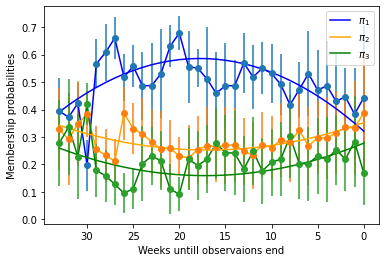

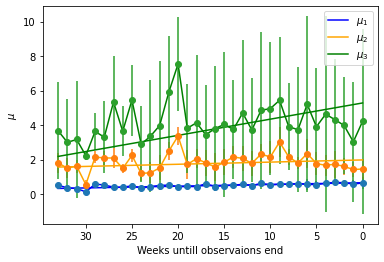

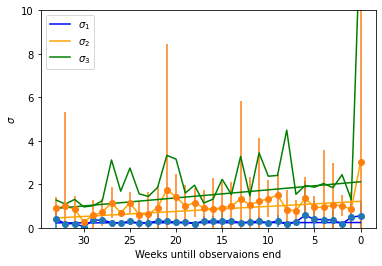

In [41]:
#plot the fits 
plt.errorbar(x, pi1, yerr=u_pi1, fmt='o')
plt.errorbar(x, pi2, yerr=u_pi2, fmt='o')
plt.errorbar(x, pi3, yerr=u_pi3, fmt='o')
plt.plot(pi1, label = '$\pi_1$', c = 'blue')
plt.plot(pi2,label = '$\pi_2$', c = 'orange')
plt.plot(pi3,label = '$\pi_3$', c = 'green')
plt.plot(quad(x,*popt_pi1), c = 'blue')
plt.plot(quad(x,*popt_pi2), c = 'orange')
plt.plot(quad(x,*popt_pi3), c = 'green')
plt.legend()
plt.xlabel('Weeks untill observaions end')
plt.ylabel('Membership probabilities')
plt.gca().invert_xaxis()
plt.show()

    
plt.errorbar(x, mu1, yerr=u_mu1, fmt='o')
plt.errorbar(x, mu2, yerr=u_mu2, fmt='o')
plt.errorbar(x, mu3, yerr=u_mu3, fmt='o')
plt.plot(mu1, label = '$\mu_1$', c ='b')
plt.plot(mu2, label = '$\mu_2$', c = 'orange')
plt.plot(mu3,  label = '$\mu_3$', c = 'g')
plt.plot(linear(x,*popt_mu1), c ='b')
plt.plot(linear(x,*popt_mu2), c ='orange')
plt.plot(linear(x,*popt_mu3), c ='g')
plt.legend()
plt.xlabel('Weeks untill observaions end')
plt.ylabel('$\mu$')
plt.gca().invert_xaxis()
plt.show()


plt.errorbar(x, s1, yerr=u_s1, fmt='o')
plt.errorbar(x, s2, yerr=u_s2, fmt='o')
# plt.errorbar(x, s3, yerr=u_s3, fmt='o')    #the error bars as one might expect are huge
plt.plot(s1,  label = '$\sigma_1$', c = 'b')
plt.plot(s2,  label = '$\sigma_2$', c = 'orange')
plt.plot(s3,  label = '$\sigma_3$', c = 'g')
plt.plot(linear(x,*popt_s1), c ='b')
plt.plot(linear(x,*popt_s2), c ='orange')
plt.plot(linear(x,*popt_s3), c ='g')
plt.legend()
plt.xlabel('Weeks untill observaions end')
plt.ylabel('$\sigma$')
plt.gca().invert_xaxis()
plt.ylim(0,10)
plt.show()

Looking at the resuts and with the power of hindsight I could probably treat the means and sigmas as constants. The most interesting part is how the membership probabilities change. The longer processes become more favourable in the data over time! 

To reineforce what I am doing. The data is drawn from either 1 of 3 guassians at a given time. The mean, standard deviation and probability that the data is drawn from a particular guassian is time dependant governed by the fits above. I realises that a potential pitfall to modeling the membership probabilities this way is that they wont sum up 1 so I might have to normalise them. 

In [42]:
#set up array to make predictions for the next 8 weeks any longer than that im not sure my model will hold since ill get negative probabilites.
n_points = 400
pred = np.random.uniform(-8, 0, n_points)
#set up storage for predictions
y_out = np.zeros(n_points)

#define  gaussians 
def gauss(x, mu, sigma): 
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)



for i, x in enumerate(pred):
    #get predicted parameters 
    u1 = linear(x,*popt_mu1)
    u2 = linear(x,*popt_mu2)
    u3 = linear(x,*popt_mu3)
    
    sig1= linear(x,*popt_s1)
    sig2= linear(x,*popt_s2)
    sig3= linear(x,*popt_s3)
    #get predicted memebrships 
    mem1 = quad(x,*popt_pi1)
    mem2 = quad(x,*popt_pi2)
    mem3 = quad(x,*popt_pi3) 
    #normalise so they always sum up to 1 
    mem_sum = mem1+mem2+mem3
    mem1 = mem1/mem_sum
    mem2 = mem2/mem_sum
    mem3 = mem3/mem_sum
    
    probability = [mem1,mem2,mem3]
    #predicted values 
    y1 = np.random.normal(loc=u1, scale=sig1)
    y2 =  np.random.normal(loc=u2, scale=sig2)
    y3 =  np.random.normal(loc=u3, scale=sig3)
    outputs = [y1,y2,y3]
    #now draw an output based on the probability
    yi = np.random.choice(outputs, p=probability)
    y_out[i] = yi

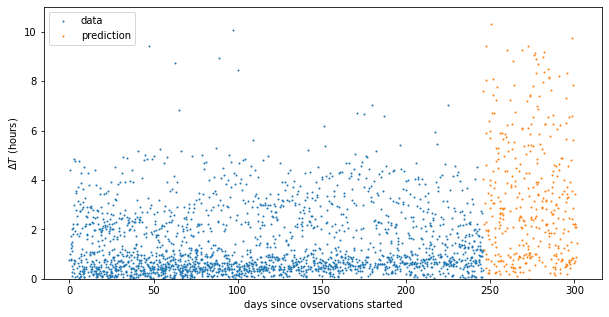

In [45]:
#to plot the prediction we need to shift the predictions times such that it starts at 245.64 days!
#at the moment the prediciton times is in weeks.

#convert to days
pred_d = pred*7
#now normalise it so the minimum value is 245.64
min_pred_d = min(pred_d)
new_pred = pred_d + (245.64-min_pred_d)
#reverse the matrix
new_pred = new_pred[::-1]

# print(new_pred)
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(start_d, dt, s = 1, label = 'data')
ax.set_xlabel('days since ovservations started')
ax.scatter(new_pred,y_out, s = 1, label = 'prediction')
ax.set_ylabel('$\Delta T$ (hours)')
ax.legend()
ax.set_ylim(0,11)
plt.show()

Wow! It turned out kind of well. I think the biggest factor thats effecting my predictions is the fit to the membership probabilities, for which it will end up favouring a more diffused prediction with almost no short cycles in the future. Some things that I am not so happy about is number of large amount of $\Delta T$ greater than 5 hours this a result of the relatively steep linear fit to $\mu_3$ and the rise in $\pi_3$.